In [1]:
# # Google Colab
# !git clone https://github.com/MiShutov/QuantizationBasics.git

# import sys
# sys.path.append("/content/QuantizationBasics")

# !pip install -r /content/QuantizationBasics/requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

import os
import torch
import  matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification
from torch.utils.data import DataLoader
import datasets


from resources.quantization_tools import *
from resources.wrapper import Wrapper
from resources.evaluation import eval
from resources.utils import prepare_dataset, print_file_size
from resources.finetuning import prepare_for_finetuning, ce_finetune, kd_finetune
from resources.bit_per_weight import get_model_bit_per_weight

device = 'cuda'

/home/msst/miniconda3/envs/quant_basics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<small>

#### NotYourLady/ImageNetPart
- part of imagenet-1k (10k train, 2.5k test)
- **1.5Gb** will take up disk space - if you use:  

```python
datasets.load_dataset('NotYourLady/ImageNetPart')
```

- **17Gb** will take up disk space - if you use (map all dataset):  

```python
resources.prepare_dataset(
	dataset_name = 'NotYourLady/ImageNetPart',
 	model_name = microsoft/resnet-18,
 	cache_dir = /your/cache/dir,
 	split=["train", "test"]
)  
```


####     NotYourLady/BetterImageNet
- part of imagenet-1k (255k train, 50k test)
- **36Gb** will take up disk space - if you use:  

```python
datasets.load_dataset('NotYourLady/BetterImageNet')
```

- **205Gb** will take up disk space - if you use (map all dataset):  

```python
resources.prepare_dataset(
	dataset_name = 'NotYourLady/BetterImageNet',
	model_name = microsoft/resnet-18,
	cache_dir = /your/cache/dir,
	split=["train[:100000]", "test"]
)
```
</small>

In [27]:
model_name = 'microsoft/resnet-18'

dataset_name = 'NotYourLady/ImageNetPart'
#dataset_name = 'NotYourLady/BetterImageNet'

model_save_path = 'models'
cache_dir='dataset'

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)

In [4]:
model = AutoModelForImageClassification.from_pretrained(model_name).to(device)
path_to_pretrained_resnet18 = os.path.join(model_save_path, 'pretrained_resnet-18')
model.save_pretrained(path_to_pretrained_resnet18)

In [5]:
dataset_prepared = (os.path.exists(os.path.join(cache_dir, "train")) and 
                   os.path.exists(os.path.join(cache_dir, "test")))

if not dataset_prepared:
    split=["train", "test"] # if use 'NotYourLady/ImageNetPart'
    # split=["train[:100000]", "test"] # if use 'NotYourLady/BettetImageNet'
    prepare_dataset(dataset_name, model_name, cache_dir, split=split)

Saving the dataset (4/4 shards): 100%|██████████| 2500/2500 [00:00<00:00, 2930.85 examples/s]


In [6]:
test_dataset = datasets.load_from_disk(os.path.join(cache_dir, 'test'))
train_dataset = datasets.load_from_disk(os.path.join(cache_dir, 'train'))

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

## FP32 
Just load pretrained model

In [7]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model)
print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.69598, 'top_5_accuracy': 0.89094}

path_to_save = os.path.join(model_save_path, 'resnet_fp32.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)
# 44.678 Mb

bit/weight: 32.00
Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

{'top_1_accuracy': 0.6896, 'top_5_accuracy': 0.886}
44.678 Mb


## FP16
Convert all weights to fp16

In [8]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
model = model.half()
get_model_bit_per_weight(model)
with torch.autocast(device_type='cuda'):
    print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.69592, 'top_5_accuracy': 0.89086}

path_to_save = os.path.join(path_to_pretrained_resnet18, 'resnet_fp16.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)
# 22.363 Mb

bit/weight: 16.00
Run evaluation...


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]

{'top_1_accuracy': 0.6896, 'top_5_accuracy': 0.8856}
22.363 Mb


## INT8
Quantize all convolutions and dense layers in 8-bit, store all other weights in 32 bit.

In [9]:
from resources.wrap_configs import INT8_CONFIG, INFERENCE_CONFIG

model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model, INT8_CONFIG)
Wrapper(**INT8_CONFIG).wrap_model(model)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.69446, 'top_5_accuracy': 0.88984}

bit/weight: 8.02
Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

{'top_1_accuracy': 0.6852, 'top_5_accuracy': 0.8852}


##### Save quantized model and check how much disk space it takes up

In [10]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)
print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.69446, 'top_5_accuracy': 0.88984}

path_to_save = os.path.join(model_save_path, 'resnet_8bit.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]

{'top_1_accuracy': 0.6852, 'top_5_accuracy': 0.8852}
11.277 Mb


## INT4

In [11]:
from resources.wrap_configs import INT4_PER_TENSOR_CONFIG, INT4_PER_CHANNEL_CONFIG, INFERENCE_CONFIG

#### Naive datafree 4-bit quantization

In [12]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model, INT4_PER_TENSOR_CONFIG)
Wrapper(**INT4_PER_TENSOR_CONFIG).wrap_model(model)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.00266, 'top_5_accuracy': 0.01116}

bit/weight: 4.20
Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

{'top_1_accuracy': 0.0032, 'top_5_accuracy': 0.0116}


#### Finetuning using CrossEntropy (CE) loss

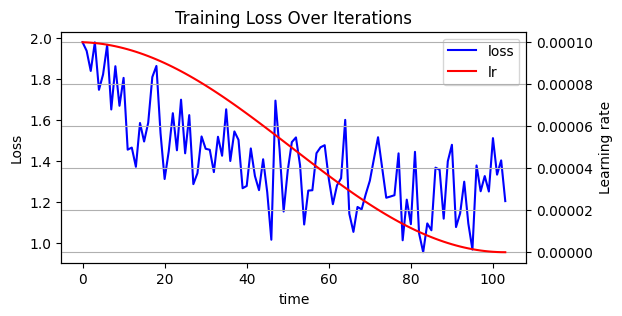

Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.49it/s]

{'top_1_accuracy': 0.632, 'top_5_accuracy': 0.8456}


In [13]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_TENSOR_CONFIG).wrap_model(model)

train_batch_size = 32
n_epochs = 1
train_lr = 1e-4

train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=len(train_loader)//100
)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.67662, 'top_5_accuracy': 0.8796} #lr=1e-4 bs=32 (100k dataset)

In [14]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

path_to_save = os.path.join(model_save_path, 'resnet_4bit_ce.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

5.957 Mb


#### Evaluate compessed model
(1) initialize quant model -> (2) evaluate -> (3) load pretrained quantized weights -> (4) evaluate

In [15]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model, INT4_PER_TENSOR_CONFIG)
Wrapper(**INT4_PER_TENSOR_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

print('Naive datafree:', eval(model, test_loader, verbose=False))

path_to_load = os.path.join(model_save_path, 'resnet_4bit_ce.pth')
print(f'Load state_dict {path_to_load}...')
print_file_size(path_to_load)
model.load_state_dict(torch.load(path_to_load, weights_only=True))

print('After finetuning:', eval(model, test_loader, verbose=False))

bit/weight: 4.20
Naive datafree: {'top_1_accuracy': 0.0032, 'top_5_accuracy': 0.0116}
Load state_dict models/resnet_4bit_ce.pth...
5.957 Mb
After finetuning: {'top_1_accuracy': 0.632, 'top_5_accuracy': 0.8456}


#### Per channel datafree

In [16]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model, INT4_PER_CHANNEL_CONFIG)
Wrapper(**INT4_PER_CHANNEL_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.61574, 'top_5_accuracy': 0.83966}

path_to_save = os.path.join(model_save_path, 'resnet_4bit_per_channel_init.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

bit/weight: 4.24
Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

{'top_1_accuracy': 0.6132, 'top_5_accuracy': 0.8356}
6.004 Mb


#### Per channel with CE finetuning

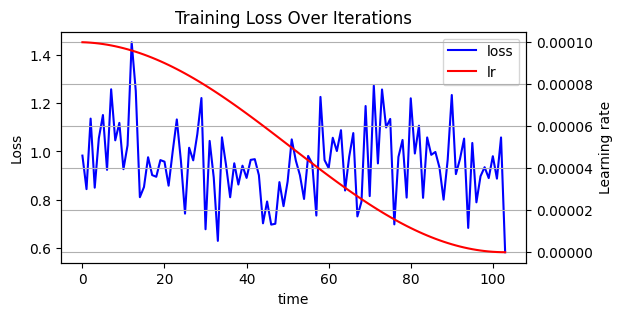

Run evaluation...


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

{'top_1_accuracy': 0.6804, 'top_5_accuracy': 0.8808}


In [17]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_CHANNEL_CONFIG).wrap_model(model)


train_batch_size = 32
n_epochs = 1
train_lr = 1e-4

train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=len(train_loader)//100
)


print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.6906, 'top_5_accuracy': 0.88532} lr=1e-4 bs=32 (100k dataset)

In [18]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)
path_to_save = os.path.join(model_save_path, 'resnet_4bit_per_channel_ce.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

6.004 Mb


## INT3
In this section of the we will use channel quantization straight away.

In [19]:
from resources.wrap_configs import INT3_PER_CHANNEL_CONFIG, INFERENCE_CONFIG

#### Datafree

In [20]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model, INT3_PER_CHANNEL_CONFIG)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.0012, 'top_5_accuracy': 0.0063} 

bit/weight: 3.28
Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

{'top_1_accuracy': 0.0008, 'top_5_accuracy': 0.0028}


#### CE finetuning

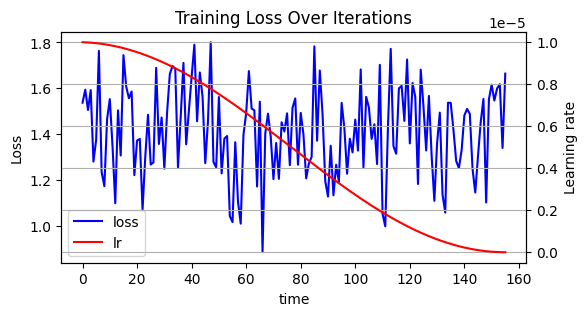

Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

{'top_1_accuracy': 0.6116, 'top_5_accuracy': 0.8304}


In [21]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)

train_batch_size = 64
n_epochs = 1
train_lr = 1e-5

train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=len(train_loader)//100
)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.6613, 'top_5_accuracy': 0.8689} lr=1e-5 bs=16 (50k dataset)


#### Knowledge Distillation (KD) finetuning

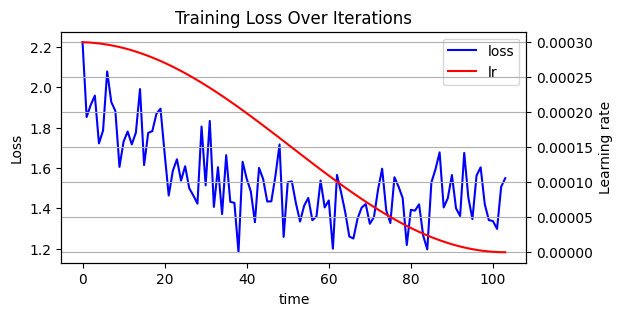

Run evaluation...


100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

{'top_1_accuracy': 0.6512, 'top_5_accuracy': 0.8664}


In [22]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)


train_batch_size = 16
n_epochs = 1
train_lr = 3e-4


teacher_model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

kd_finetune(
        model, 
        teacher_model,
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=len(train_loader)//100,
        T=2,
        ce_loss_weight=0.75
)

print(eval(model, test_loader))
# full_test: {'top_1_accuracy': 0.66966, 'top_5_accuracy': 0.87476} lr=3e-4 bs=16 (100k dataset)

In [23]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)
path_to_save = os.path.join(model_save_path, 'resnet_3bit_per_channel_kd.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

4.674 Mb


#### Evaluate compessed model
(1) initialize quant model -> (2) evaluate -> (3) load pretrained quantized weights -> (4) evaluate

In [24]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
get_model_bit_per_weight(model, INT3_PER_CHANNEL_CONFIG)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

print('Naive datafree:', eval(model, test_loader, verbose=False))

path_to_load = os.path.join(model_save_path, 'resnet_3bit_per_channel_kd.pth')
print(f'Load state_dict {path_to_load}...')
print_file_size(path_to_load)
model.load_state_dict(torch.load(path_to_load, weights_only=True))

print('After finetuning:', eval(model, test_loader, verbose=False))


bit/weight: 3.28
Naive datafree: {'top_1_accuracy': 0.0008, 'top_5_accuracy': 0.0028}
Load state_dict models/resnet_3bit_per_channel_kd.pth...
4.674 Mb
After finetuning: {'top_1_accuracy': 0.6512, 'top_5_accuracy': 0.8664}


### Results

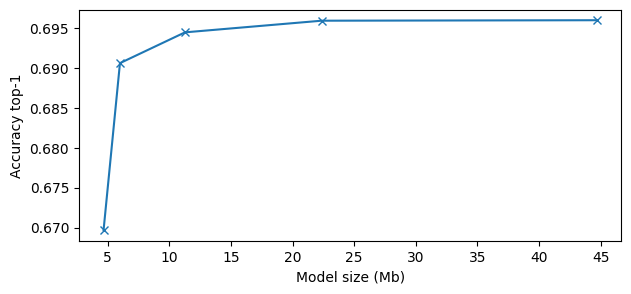

In [25]:
results = {
    'model size (Mb)': [44.678, 22.363, 11.277, 6.004, 4.674],
    'accuracy top-1': [0.69598, 0.69592, 0.69446, 0.6906, 0.66966]
}

fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(results['model size (Mb)'], results['accuracy top-1'], marker='x')

ax.set_xlabel('Model size (Mb)')
ax.set_ylabel('Accuracy top-1')

plt.show()